# Jane Street: Problem appreciation

So, the competition has come to an end and I would like to congratulate everyone who dived deeper into solving the problem statement posed by Jane Street. This was a very challenging problem and coming with a working solution deserves credit, so great job to all participants on the private leader board.

To show just how complex the relationships are within the problem I made this notebook which was inspired from this [notebook](https://www.kaggle.com/yanamal/questions-tags-and-lectures-riiid-metadata-eda) from a different Kaggle challenge . So be proud for having a crack at such a complex problem.


In [1]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datatable
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#Loading train data
train = pd.read_csv('../input/jane-street-market-prediction/train.csv')
features = pd.read_csv('../input/jane-street-market-prediction/features.csv')
train.fillna(train.mean(), inplace = True) #fill empty data with mean
#Scaling values
val = train.values #returns a numpy array
scaler = MinMaxScaler()
scaled_vals = scaler.fit_transform(val)
train_scaled = pd.DataFrame(scaled_vals, columns = train.columns)

Will be creating a dataframe with all tags and features which we can then be use for some analysis on how the tags can be connected with the features. Perhaps there are tags which only ever appear with certain features allowing us for further understanding of this relationship.

In [3]:
def features_with_tags(df):
    features_ds = df[df]
    cols = features_ds.columns
    number_cols = len(features_ds.index)
    list_df = []
    
    for idx_col in range(0, number_cols):
        ds = features_ds.iloc[idx_col]
        ds = ds[ds == 1].to_frame()
        ds.reset_index(inplace = True)
        
        cols_ds = ds.columns
        ds[cols_ds[1]] = ds[cols_ds[0]]
        ds.drop(cols_ds[0], axis = 1, inplace = True)
        list_df.append(ds)
    
    out_df = pd.concat(list_df, axis = 1, sort = False).T
    out_df.fillna('None', inplace = True)
    
    
    return out_df


# Feature vs Tags
As we all came to know this relationship baffled many, including me. I spent approxmately 2 months on this alone trying to find some way of understanding, quantifying, heck just anything menaingful from the table. I would like to the feature vs tags table again to show that relationships between features and tag were not simple but extemely complex.

In [4]:
features.set_index('feature', inplace = True)
features_with_tags_df = features_with_tags(features)
features_with_tags_df.style.applymap(lambda x: 'background-color : yellow' if x == 'None' else '')

,0,1,2,3
feature_0,None,None,None,None
feature_1,tag_6,tag_7,None,None
feature_2,tag_6,tag_7,tag_9,None
feature_3,tag_6,tag_8,None,None
feature_4,tag_6,tag_8,tag_9,None
feature_5,tag_6,tag_10,None,None
feature_6,tag_6,tag_9,tag_10,None
feature_7,tag_4,tag_6,tag_11,None
feature_8,tag_4,tag_6,tag_9,tag_11
feature_9,tag_0,tag_6,tag_11,None


In [5]:
features_with_tags_df['tags'] = features_with_tags_df.values.tolist()
features_with_tags_df.drop([0, 1, 2, 3], axis = 1, inplace = True)
features_with_tags_df.reset_index(inplace = True)

In [6]:
# Topology function
def tag_relationship_graph (tags, show_disconnected = False, print_values = False, return_graph = False, title = ""):
    G = nx.Graph()
    for i in tags.index:
        first_tag = tags.loc[i]['tag']
        first_ft = tags.loc[i]['features']
        
        if show_disconnected:
            G.add_node(first_tag)
        for _, second_row in tags.loc[i:].iterrows():
            second_tag = second_row['tag']
            second_qs = second_row['features']
            if first_tag != second_tag:
                ft_in_common = len(first_ft.intersection(second_qs))
                if ft_in_common > 0:
                    G.add_edge(first_tag, second_tag, color = 'g' ,weight = ft_in_common)
                    if print_values:
                        print(f'{first_tag} <=> {second_tag}:{ft_in_common}')
                        
                        
    pos = nx.spring_layout(G)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    
    fig, ax = plt.subplots(figsize = (15,15))
    nx.draw(G, pos = pos, node_color = 'yellow', with_labels = True, ax = ax, edgelist = edges, edge_color = weights, width = 5.0, edge_cmap = plt.cm.Blues)
    nx.draw_networkx_edge_labels(G, pos = pos, edge_labels = nx.get_edge_attributes(G, 'weight'))
    plt.title(title)
    plt.show()
    
    if return_graph:
        return G

In [7]:
tag_to_features = {}

for i, row in features_with_tags_df.iterrows():
    for t in row['tags']:
        if t not in tag_to_features:
            tag_to_features[t] = set()
        tag_to_features[t].add(row['index'])
tags_df = pd.DataFrame([{'tag': t, 'features': ft} for t, ft in tag_to_features.items()])




# Relationship between tags and features
In this section of the problem, I take the tags and ask myself what is the relationship between tags? Are there tags which only appear for some features and not for others? 

What emerged was an extremely complex graph which showed that some tags were used with others more often, but it was not completely exclusive i.e. one tag maybe common with a set of features but that does not mean they are similar in nature.

This added another layer of complexity and this problem had not only 12 or 20 features but 130 of them! So removing features as form of feature engineering was not optimal simply due to this observation (which I think some Kagglers tried to do)

In [8]:
tags_df.head(10)

,tag,features
0,None,"{feature_29, feature_56, feature_41, feature_2..."
1,tag_6,"{feature_29, feature_21, feature_32, feature_3..."
2,tag_7,"{feature_2, feature_1}"
3,tag_9,"{feature_32, feature_36, feature_6, feature_22..."
4,tag_8,"{feature_3, feature_4}"
5,tag_10,"{feature_6, feature_5}"
6,tag_4,"{feature_18, feature_8, feature_28, feature_96..."
7,tag_11,"{feature_8, feature_10, feature_7, feature_14,..."
8,tag_0,"{feature_103, feature_29, feature_56, feature_..."
9,tag_3,"{feature_21, feature_32, feature_125, feature_..."


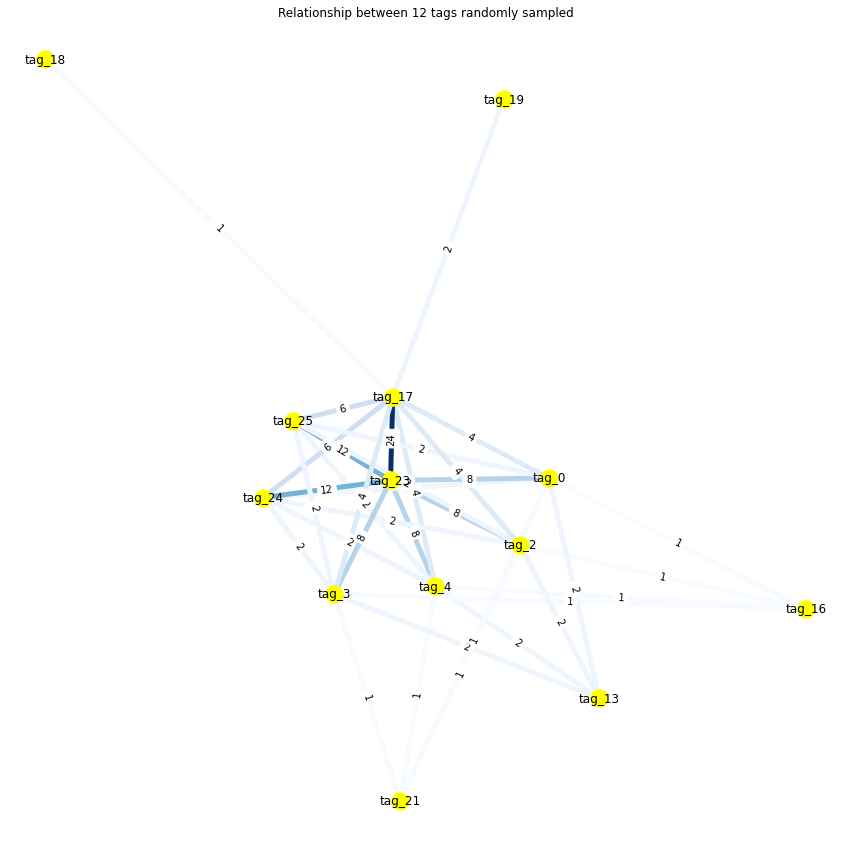

In [9]:
tag_relationship_graph(tags_df.sample(frac= 0.5, replace = False, random_state = np.random.RandomState()), title = "Relationship between 12 tags randomly sampled")

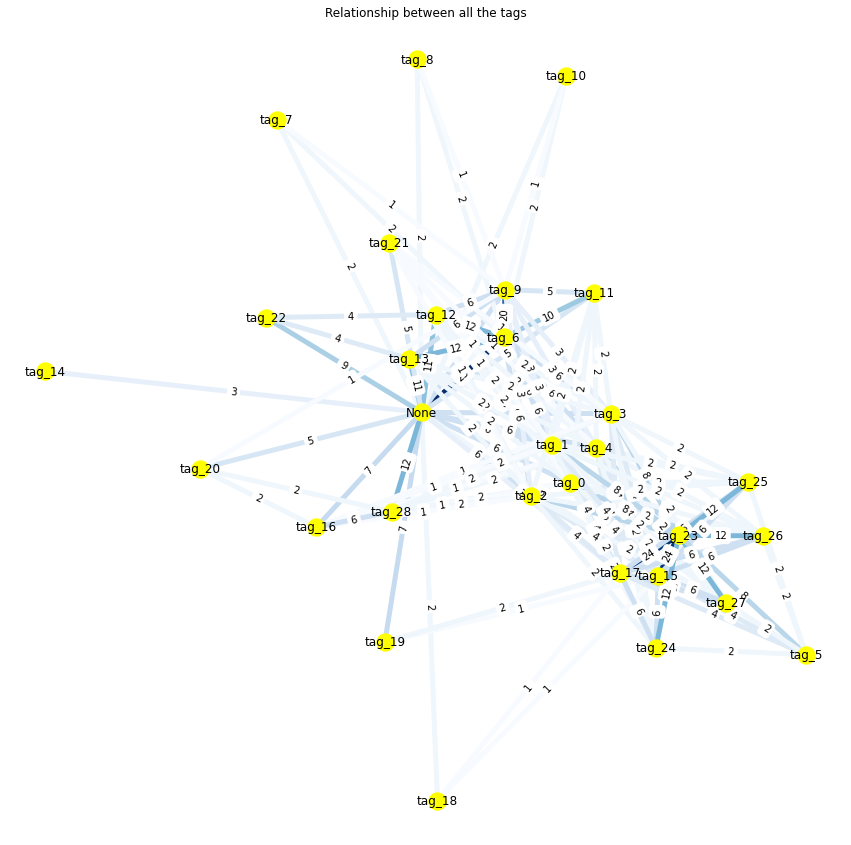

In [10]:
tag_relationship_graph(tags_df,  title = "Relationship between all the tags")

There is not much to say here other than expressing the wow factor looking at this graph.

## Closing comments
This was an exceedingly difficult machine learning problem to solve. I hope these graphs can illustrate the complex relationships existing between the feature set and their tag descriptions. I do know that some awesome Kagglers have decomposed a few features! which is mind blowing and that just shows how incredibly fun this problem was to work with. So if you have managed to have a crack at this problem and tried to decipher the complex relationships existing within the features then hats off to you!!

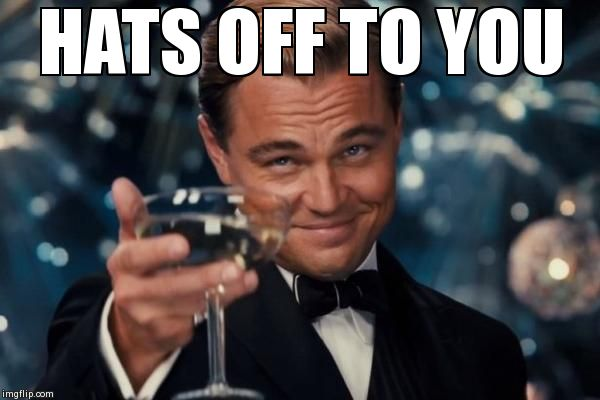